In [6]:
# set module auto-reloaded 
%load_ext autoreload
%autoreload 2

In [7]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# Allocation of 17179869184 exceeds 10% of free system memory.

In [8]:
# Load MNIST data set
from tensorflow.keras.datasets import mnist
train_set, test_set = mnist.load_data()

In [16]:
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow import keras
import numpy as np

from regularization import calculate_histogram, test_histogram, calculate_histogram_range, calculate_entropy, calc_sparsity_regularization

kernel_initializer = 'he_normal'
activation = "relu"

# Generate a simple NN model
def get_model(channels=128):
    shape=(28,28,1)
    
    inputs = Input(shape)
    layer = Flatten()(inputs)
    layer = Dense(units=channels*2, activation=activation, kernel_initializer=kernel_initializer)(layer)
    layer = Dense(units=channels, activation=activation, kernel_initializer=kernel_initializer)(layer)
    output = Dense(10, activation='linear', use_bias=True, kernel_initializer=kernel_initializer)(layer)

    model = Model(inputs, output)
    return model

In [20]:
class CompressibleNN(keras.Model):
    def __init__(self, net_model):
        super(CompressibleNN, self).__init__()
        self.net_model = net_model
        self.CE_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    def call(self, inputs):
        return self.net_model(inputs)
    
    def entropy_loss(self, inputs):
        entropy = 0
        
        for l in self.net_model.layers:
            if isinstance(l, keras.layers.Dense):
                for v in l.trainable_variables:
                    v_entropy, v_range = calculate_entropy(v)
                    entropy += v_entropy
        
        return entropy
    
    def regularization_loss(self, inputs, regularization_weighting_coefficient = 1e-2):
        rg_loss = 0
        num_activations = 0  # Initialize the total number of activations
        
        for l in self.net_model.layers:
            if isinstance(l, keras.layers.Dense):
                for v in l.trainable_variables:
                    num_activations += tf.reduce_prod(v.shape)  # Accumulate the number of activations
                    v_regularization_loss = calc_sparsity_regularization(v)
                    rg_loss += v_regularization_loss

        # Divide the total regularization loss by the total number of activations
        rg_loss = rg_loss * regularization_weighting_coefficient / tf.cast(num_activations, dtype=tf.float32)
        
        return rg_loss
    
    
    def train_step(self, input):
        images = input[0]
        labels = input[1]

        with tf.GradientTape() as tape:
            output = self.net_model(images)
            loss =  self.entropy_loss(images)
            regularization_loss = self.regularization_loss(images)

        # 1. Entropy-based regularization
        # Get the gradients w.r.t the loss
        gradient = tape.gradient(loss, self.net_model.trainable_variables)
        # Update the weights using the generator optimizer
        self.optimizer.apply_gradients(
            zip(gradient, self.net_model.trainable_variables)
        )
        return {"loss": loss}

        # 2. Sparsity-based regularization
#         gradient_reg = tape.gradient(regularization_loss, self.net_model.trainable_variables)
#         # Update the weights using the generator optimizer
#         self.optimizer.apply_gradients(
#             zip(gradient_reg, self.net_model.trainable_variables)
#         )
#         return {"regularization loss": regularization_loss}
    
model = get_model()
compNN = CompressibleNN(model)
optimizer = tf.optimizers.Adam(learning_rate=1e-3, beta_1=0.9)
compNN.compile(optimizer, loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))

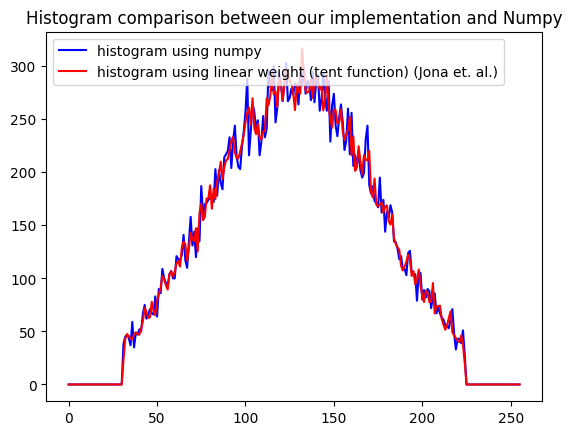

In [21]:
from regularization import visualize_histogram
variables=model.layers[3].variables[0]
visualize_histogram(variables)

In [24]:
# train the model
tf.config.run_functions_eagerly(True)
# loss needs to be decreased during training
compNN.fit(x=train_set[0], y=train_set[1], epochs=1, batch_size=32)


   1/1875 [..............................] - ETA: 1:25:37 - loss: 24.3669

KeyboardInterrupt: 

In [ ]:
# test performance
res = model(test_set[0])
print("test acc: ", 100*(np.argmax(res, axis=1)==test_set[1]).mean())

In [ ]:
# test performance with entropy_loss
res = model(test_set[0])
print("test acc: ", 100*(np.argmax(res, axis=1)==test_set[1]).mean())

In [ ]:
 17.7708
 17.7171
 17.6588
 